This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

You can download the dataset from kaggle

https://www.kaggle.com/snap/amazon-fine-food-reviews


The purpose of this model is to show an example of using fastText model for some supervised and unsupervised learning on a csv file.

In [1]:
import fastText
import pandas as pd
from sklearn.model_selection import train_test_split
import csv
import re
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

## Data preprocessing

Make the transformations in the csv to make it fastText compatible.

1. Label column should be first and all the needed text should be the second column
1. The labels should be prefixed with '__label__'.

In [2]:
df = pd.read_csv('data/amazon_reviews.csv')
df = df[['Score', 'Text']]
df['Score'] = df['Score'].apply(lambda x: '__label__'+str(x))

Some basic normalization

In [3]:
def normalize(s):
    """
    Given a text, cleans and normalizes it. Feel free to add your own stuff.
    """
    s = s.lower()
    # Replace ips
    s = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' _ip_ ', s)
    # Isolate punctuation
    s = re.sub(r'([.\(\)\!\?\-\\\/\,])', r' \1 ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Replace numbers and symbols with language
    s = s.replace('&', ' and ')
    s = s.replace('@', ' at ')
    s = s.replace('0', ' zero ')
    s = s.replace('1', ' one ')
    s = s.replace('2', ' two ')
    s = s.replace('3', ' three ')
    s = s.replace('4', ' four ')
    s = s.replace('5', ' five ')
    s = s.replace('6', ' six ')
    s = s.replace('7', ' seven ')
    s = s.replace('8', ' eight ')
    s = s.replace('9', ' nine ')
    return s

In [4]:
# Convert all upper case to lower case and separate out the punctuations
df['Text'] = df['Text'].apply(normalize)

Split the whole dataset into training and validation.
Then you will need to save the file generated. fastText uses the c++ api of the internal so that it is fasttext and it is able to read from a file only. Hence you cannot pass pandas dataframe or other general objects into fastText directly. It needs to be saved in a text file format.  Acceptable separators: space '\s' and tabs '\t'

In [5]:
train, test = train_test_split(df, test_size=0.2)
train_file = 'data/ft_amazon_reviews_train.csv'
test_file = 'data/ft_amazon_reviews_test.csv'
train.to_csv("data/ft_amazon_reviews_train.csv", sep="\t", quoting=csv.QUOTE_NONE, index=False, header=False)
test.to_csv("data/ft_amazon_reviews_test.csv", sep="\t", quoting=csv.QUOTE_NONE, index=False, header=False)

## Model training

In [6]:
su_model = fastText.train_supervised(input=train_file, epoch=25, lr=1.0, wordNgrams=2, verbose=2, minCount=1)

In [7]:
su_model

save the model to a file

In [8]:
su_model.save_model('su_model.bin')

## Prediction

In [9]:
su_model.get_word_vector('restaurant')

array([ 0.22435586,  0.95527536, -0.44455796, -0.03951411, -0.01095253,
        0.6159792 ,  0.5153629 , -0.21586855, -0.27574384, -0.3276731 ,
       -0.22132482, -0.58282095,  0.2036461 ,  0.09942202,  0.04707805,
       -0.08876295,  0.08870561,  0.05554101,  0.10984168, -0.18077362,
        0.04535109,  0.42684075, -0.35661155,  0.00581164, -0.05114033,
        0.37843418, -0.2590034 ,  0.10909657,  0.21210743, -0.15437399,
       -0.06822666, -0.3608412 , -0.6663131 , -0.23312452, -0.2201562 ,
       -0.16252425, -0.00828634,  0.15795305, -0.3200012 , -0.13571495,
        0.3176872 , -0.06170471,  0.5234293 ,  0.42308843, -0.2997579 ,
       -0.3275955 , -0.29005194,  0.29714245, -0.07236667, -0.0490873 ,
       -0.00259931,  0.07159577, -0.14207417,  0.29956803,  0.37480626,
       -0.37832087, -0.36457762,  0.8110961 ,  0.3556552 ,  0.18856733,
        0.24436091,  0.08270382,  0.2554578 , -0.3571458 , -0.20491928,
        0.48312145,  0.2134933 ,  0.10248006, -0.40751502,  0.00

In [10]:
su_model.get_sentence_vector('I love this restaurant')

array([ 1.54103324e-01,  5.47133625e-01, -9.84371379e-02, -2.28309453e-01,
        4.92512226e-01,  4.54757243e-01, -1.92710295e-01, -1.99336186e-01,
        1.84675336e-01,  2.54244238e-01, -1.37906477e-01, -2.22580973e-03,
       -7.49833286e-02,  2.99171209e-01, -1.93358108e-01, -2.73760296e-02,
       -9.45006609e-02, -4.19891402e-02, -4.88251932e-02, -9.12335366e-02,
        1.24997519e-01,  2.20850497e-01,  2.94067830e-01, -1.16107658e-01,
       -1.62551582e-01, -9.43272114e-02,  2.36129344e-01, -4.83906381e-02,
       -3.50350678e-01,  1.99104518e-01,  1.73049979e-04, -1.78077504e-01,
       -9.40746590e-02, -2.27473795e-01, -4.10165817e-01,  1.09069034e-01,
        1.04938090e-01, -1.51514560e-01, -2.10111305e-01, -2.60049105e-02,
        2.01271940e-03,  3.02805990e-01,  1.91670917e-02,  3.23320806e-01,
        4.50405121e-01, -2.74187267e-01,  2.03039899e-01,  7.43407831e-02,
       -3.19145977e-01,  1.04817979e-01, -4.86542135e-01,  9.46902856e-02,
       -2.67558217e-01,  

In [11]:
su_model.predict('I love this restaurant')

(('__label__5',), array([1.00001001]))

Find the first 3 labels as per probabilities.

In [12]:
su_model.predict('I love this restaurant', k=3)

(('__label__5', '__label__2', '__label__3'),
 array([1.00001001e+00, 1.00000034e-05, 1.00000034e-05]))

## Model Performance

#### Pricision and recall for single label

In [13]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

In [14]:
print_results(*su_model.test(test_file))

N	113691
P@1	0.825
R@1	0.825


#### Precision and recall for multiple labels

In [15]:
n, p, r = su_model.test(test_file, 5)
print("N\t" + str(n))
print("P@{}\t{:.3f}".format(5, p))
print("R@{}\t{:.3f}".format(5, r))

N	113691
P@5	0.200
R@5	1.000


#### Confusion matrix

In [16]:
def get_true_postive_count(cm, model, df, label_column_name, text_column_name, target_class):
    predictions = [model.predict(x)[0][0] for x in df[df[label_column_name] == target_class][text_column_name]]
    tp_count = len(list(filter(lambda x: x==target_class, predictions)))
    index = np.where(cm==tp_count)
    if index[0][0] == index[1][0]:
        return index[0][0]
    else:
        raise ValueError('COuld not find the index ' + index)
        
        
def resolve_labels_sequence(classes, cm, model, df, label_column_name, text_column_name):
    target_seq = [0] * len(classes)
    for label in classes:
        index = get_true_postive_count(cm, model, df, label_column_name, text_column_name, label)
        target_seq[index] = label
    return target_seq


def fasttext_confusion_matrix(model, pd_test_data, label_column_name, text_column_name):
    test_labels = pd_test_data[label_column_name]
    test_labels = np.array(test_labels)
    _classes = list(set(test_labels))
    pred_labels = [model.predict(x)[0][0] for x in pd_test_data[text_column_name]]
    pred_labels = np.array(pred_labels)
    eq = test_labels == pred_labels
    print("Accuracy: " + str(eq.sum() / len(test_labels)))
    cm = confusion_matrix(test_labels, pred_labels)
    labels = resolve_labels_sequence(_classes, cm, model, pd_test_data, label_column_name, text_column_name)
    print(labels)
    print(confusion_matrix(test_labels, pred_labels, labels=labels))
    df_cm = pd.DataFrame(cm, index = labels, columns = labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

Accuracy: 0.8245155729125436
['__label__1', '__label__2', '__label__3', '__label__4', '__label__5']
[[ 8266   890   484   206   638]
 [ 1070  3388   777   291   497]
 [  552   704  5061  1064  1028]
 [  192   199   912  9669  5150]
 [  452   209   620  4016 67356]]


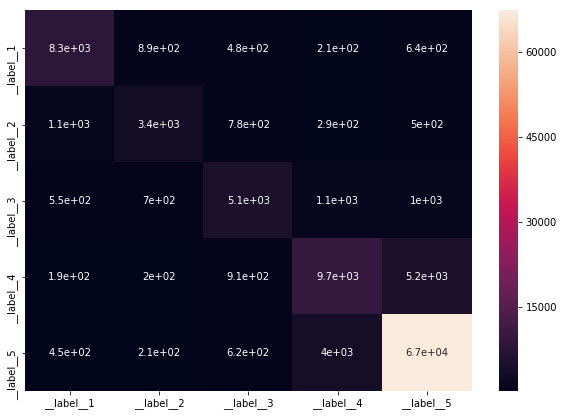

In [17]:
fasttext_confusion_matrix(su_model, test, 'Score', 'Text')